In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

In [31]:
from datasets import load_dataset

ds = load_dataset("zh-plus/tiny-imagenet")

In [32]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
IMG_CHANNELS = 3
IMG_SIZE = 64
NUM_EPOCHS = 10


In [33]:

# --- Configuration ---
IMG_SIZE = 64
BATCH_SIZE = 128

# Step 1: Define a transform function to convert PIL images to NumPy arrays
# This function will be applied on-the-fly by the Hugging Face library.
def convert_to_numpy(batch):
    # The 'image' key contains a list of PIL Image objects.
    # We convert each one to a NumPy array.
    batch["image"] = [np.array(img.convert("RGB")) for img in batch["image"]]
    return batch

# Step 2: Load the dataset and apply the initial transform
ds = load_dataset("zh-plus/tiny-imagenet")
ds.set_transform(convert_to_numpy) # This pre-converts images to NumPy arrays

# Step 3: Create the TensorFlow dataset
# Now, 'to_tf_dataset' will yield NumPy arrays, which TensorFlow understands.
raw_train_ds = ds['train'].to_tf_dataset(columns=['image'])

# Step 4: Define the final TensorFlow-only preprocessing function
# This function now receives a proper tensor.
def preprocess_tf(element):
    image = tf.image.resize(element, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image, image

# Step 5: Build the final, efficient data pipeline
train_dataset = raw_train_ds.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Dataset pipeline is ready for training! ✅")

Dataset pipeline is ready for training! ✅


/home/aditi/Documents/cae_dimensionality_reduction/cae_env/lib/python3.10/site-packages/datasets/arrow_dataset.py:405: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [34]:
print(len(ds['train']))

100000


In [25]:
from tensorflow.keras import layers, Model

def build_compact_autoencoder(input_shape=(64, 64, 3)):
    """
    Builds a compact autoencoder specifically for 64x64 images.
    """
    inputs = layers.Input(shape=input_shape)

    # --- ENCODER ---
    # Block 1: 64x64 -> 32x32
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # --- BOTTLENECK ---
    # 32x32
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # --- DECODER ---
    # Block 2: 32x32 -> 64x64
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # --- OUTPUT LAYER ---
    decoded = layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

    autoencoder = Model(inputs, decoded, name="Compact_Autoencoder")
    return autoencoder

# Build the new, more appropriate model for 64x64 images
IMG_SIZE = 64
model = build_compact_autoencoder(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Print the summary
model.summary()

Model: "Compact_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,563 (885.01 KB)

 Trainable params: 225,795 (882.01 KB)

 Non-trainable params: 768 (3.00 KB)

In [36]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

print("\nModel compiled successfully!")


Model compiled successfully!


In [38]:
import time

# Record the start time
start_time = time.time()

# Train for ONLY ONE epoch
history = model.fit(
    train_dataset,
    epochs=9
)

# Record the end time
end_time = time.time()

# Calculate and print the time for one epoch
time_per_epoch = end_time - start_time
print(f"\nOne epoch took approximately {time_per_epoch:.2f} seconds.")

Epoch 1/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 219s 278ms/step - loss: 0.0088
Epoch 2/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 219s 279ms/step - loss: 0.0073
Epoch 3/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 219s 279ms/step - loss: 0.0073
Epoch 4/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 218s 278ms/step - loss: 0.0063
Epoch 5/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 218s 277ms/step - loss: 0.0060
Epoch 6/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 218s 277ms/step - loss: 0.0056
Epoch 7/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 217s 276ms/step - loss: 0.0052
Epoch 8/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 215s 273ms/step - loss: 0.0047
Epoch 9/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 216s 274ms/step - loss: 0.0047

One epoch took approximately 1957.54 seconds.


Generating sample reconstructions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


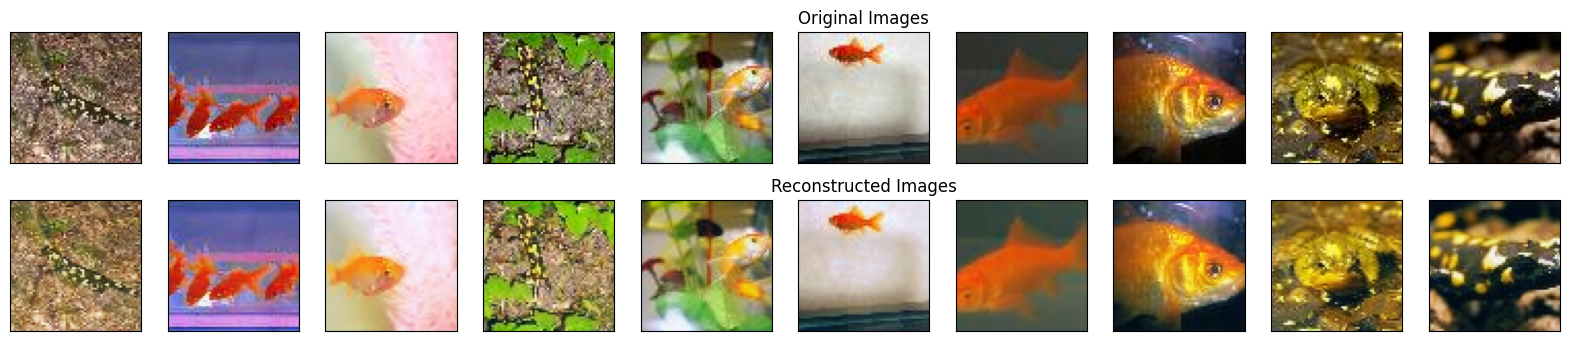

In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_reconstructions(model, dataset, num_images=10):
    print("Generating sample reconstructions...")
    
    # Get one batch of images from our dataset
    original_images, _ = next(iter(dataset))
    
    # Use the model to predict (reconstruct) the images
    reconstructed_images = model.predict(original_images)

    # IMPORTANT: Denormalize the images for correct display.
    # We're converting them from the [-1, 1] range back to the [0, 1] range.
    original_images = (original_images + 1) / 2.0
    reconstructed_images = (reconstructed_images + 1) / 2.0
    
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Display original image
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_images // 2:
            ax.set_title("Original Images")

        # Display reconstructed image
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_images // 2:
            ax.set_title("Reconstructed Images")
            
    plt.show()

# Call the function to see your results!
visualize_reconstructions(model, train_dataset)

In [40]:
# The 'convert_to_numpy' transform is already set on your main 'ds' object,
# so it will automatically apply to the 'valid' split as well.

print("Creating validation data pipeline...")

# 1. Create a raw TensorFlow dataset from the 'valid' split.
raw_valid_ds = ds['valid'].to_tf_dataset(columns=['image'])

# 2. Build the validation data pipeline using your existing 'preprocess_tf' function.
#    NOTICE: We do NOT use .shuffle() for validation or testing.
valid_dataset = raw_valid_ds.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE) # Use the same BATCH_SIZE
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

print("Validation dataset pipeline created successfully! ✅")

Creating validation data pipeline...
Validation dataset pipeline created successfully! ✅


Generating sample reconstructions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


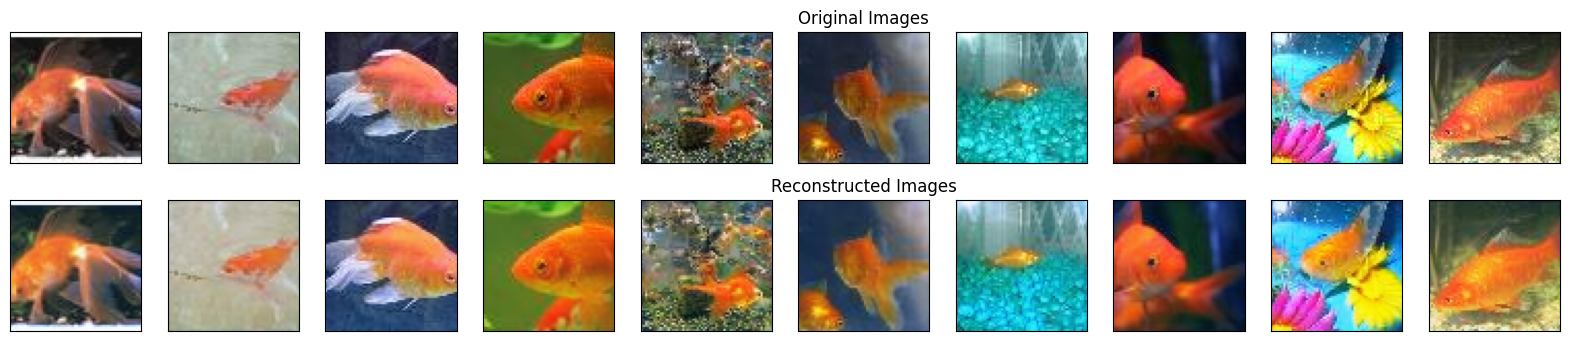

In [41]:
# Call the function with the NEW validation dataset.
visualize_reconstructions(model, valid_dataset)

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
IMG_SIZE = 64 # Make sure this matches your training image size
IMAGE_PATH = "Screenshot from 2025-06-13 10-40-59.png" # <-- IMPORTANT: Change this to the actual path of your image

# 1. Load the image using TensorFlow
try:
    # Read the file from disk
    img = tf.io.read_file(IMAGE_PATH)
    # Decode it into a tensor, specifying 3 channels for RGB
    img = tf.image.decode_image(img, channels=3)
except tf.errors.NotFoundError:
    print(f"Error: The file '{IMAGE_PATH}' was not found.")
    # Stop execution if the file doesn't exist
    # In a notebook, you might just see the error and the cell stops.
    raise

# 2. Preprocess the image (same steps as training)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
img = tf.cast(img, tf.float32) / 127.5 - 1.0

# 3. Add the batch dimension
# The model expects a shape of (batch_size, height, width, channels)
# Our image is currently (height, width, channels).
# tf.expand_dims adds a new dimension at the beginning.
# Shape goes from (64, 64, 3) -> (1, 64, 64, 3)
img_batch = tf.expand_dims(img, axis=0)

print(f"Original image shape: {img.shape}")
print(f"Shape after adding batch dimension: {img_batch.shape} ✅")

Original image shape: (64, 64, 3)
Shape after adding batch dimension: (1, 64, 64, 3) ✅


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


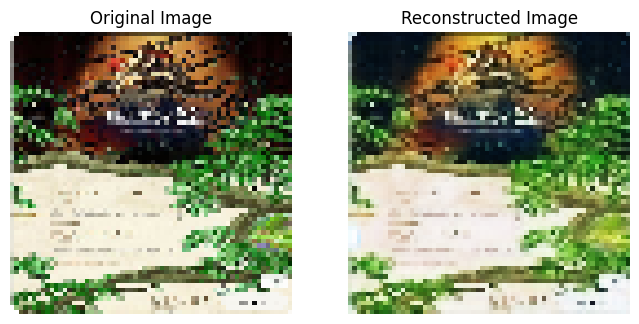

In [44]:
# 4. Get the model's prediction
reconstructed_batch = model.predict(img_batch)

# 5. Post-process for visualization
# Remove the batch dimension to get a single image back
# Shape goes from (1, 64, 64, 3) -> (64, 64, 3)
reconstructed_image = tf.squeeze(reconstructed_batch, axis=0)

# Denormalize both images from [-1, 1] back to [0, 1] for correct display
original_image_display = (img + 1) / 2.0
reconstructed_image_display = (reconstructed_image + 1) / 2.0


# 6. Display the results side-by-side
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_display)
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_display)
plt.axis('off')

plt.show()

In [46]:
# Save the model to a single file named 'my_autoencoder.h5'
model.save('my_autoencoder.keras')

print("Model saved successfully in keras format! 💾")

Model saved successfully in keras format! 💾


In [47]:
model.save_weights('my_autoencoder.weights.h5')
print('saved weights')

saved weights


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
--- Displaying Encoder Activations ---


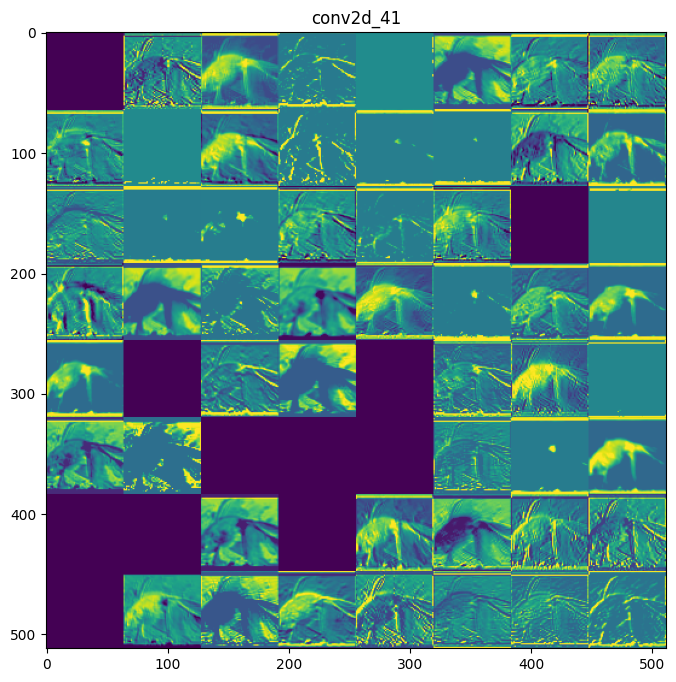

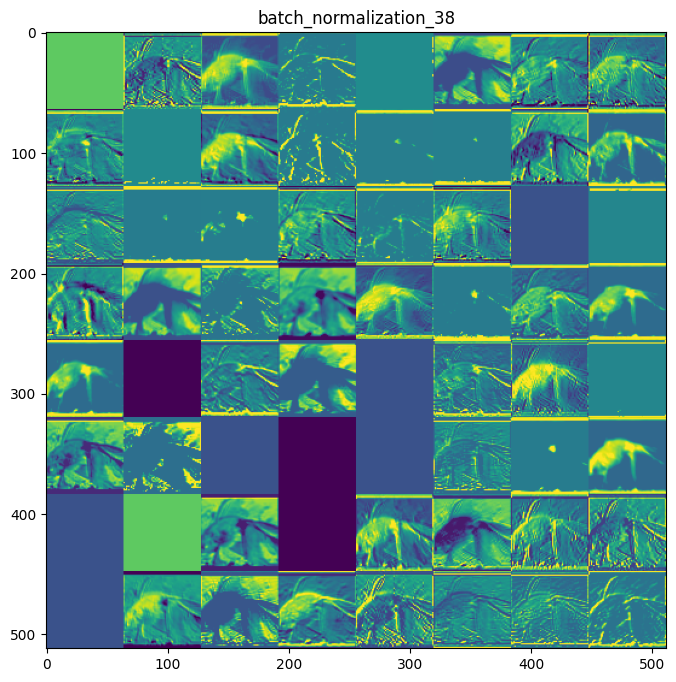

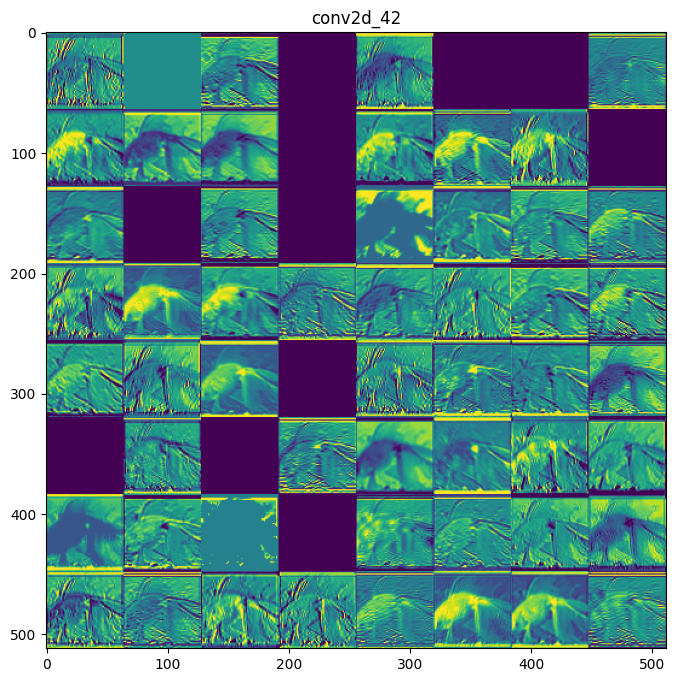

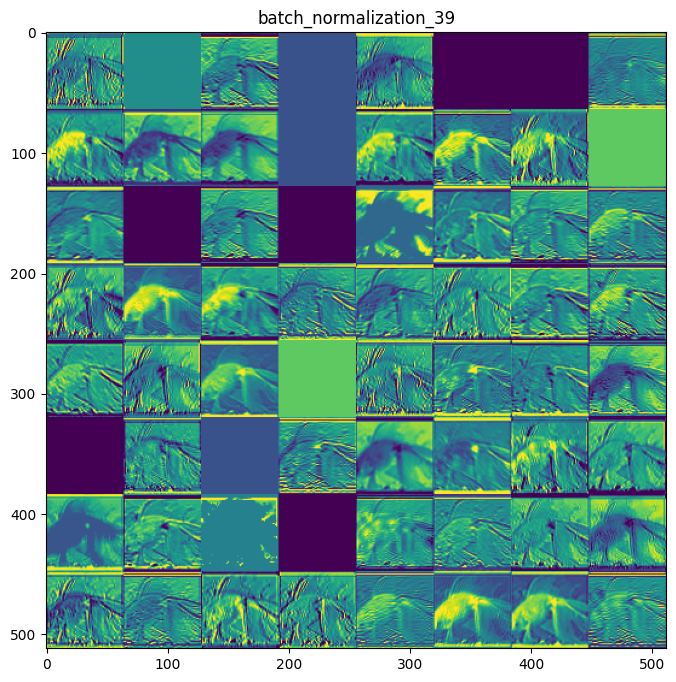

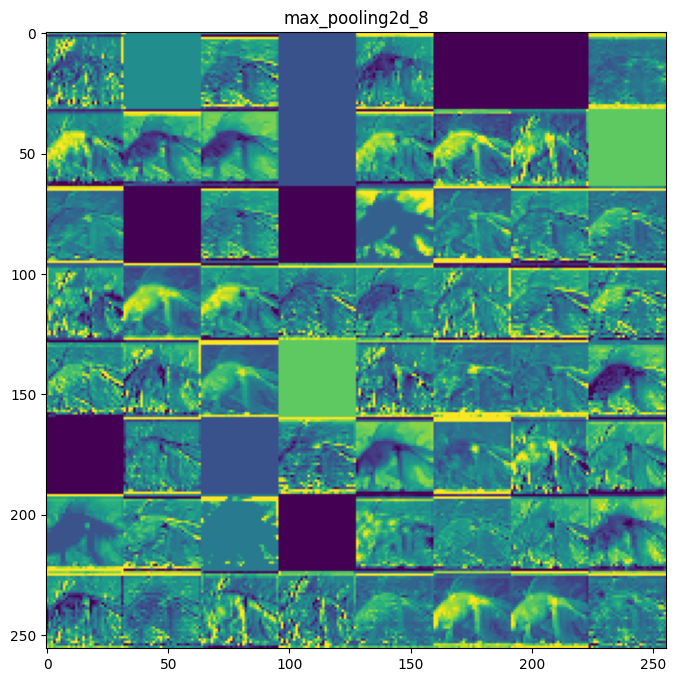


--- Displaying Bottleneck Activations ---


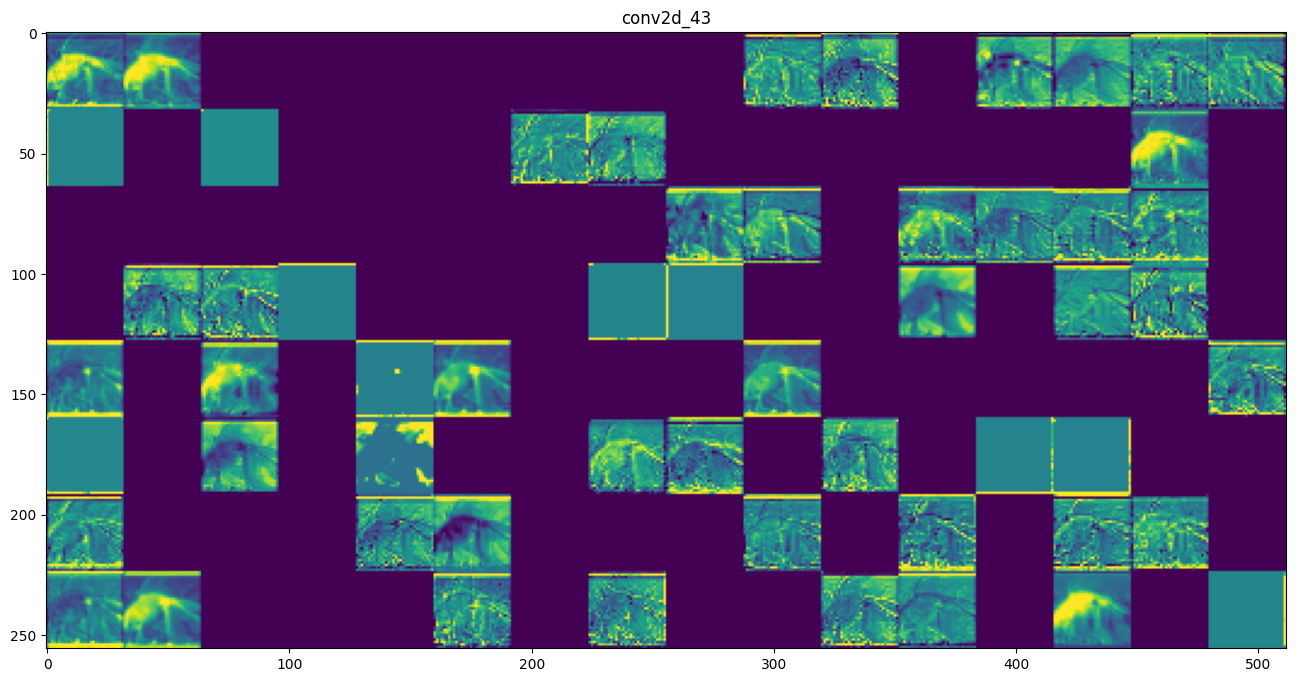

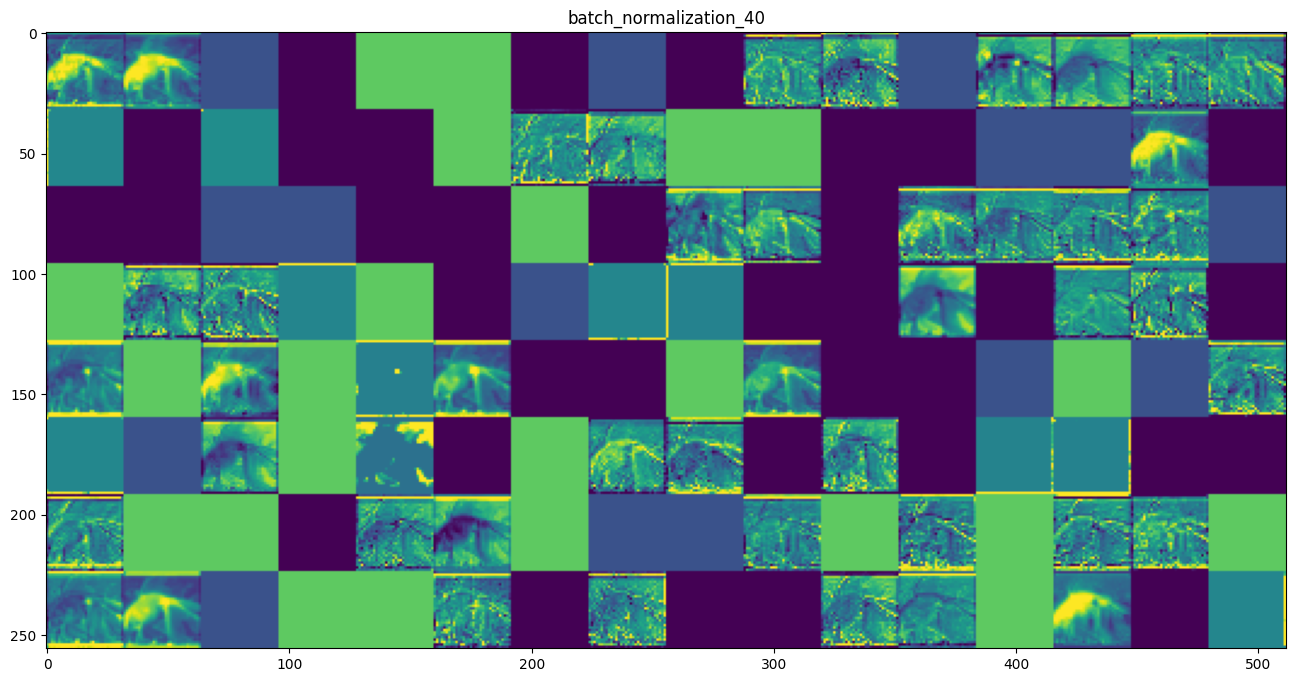


--- Displaying Decoder Activations ---


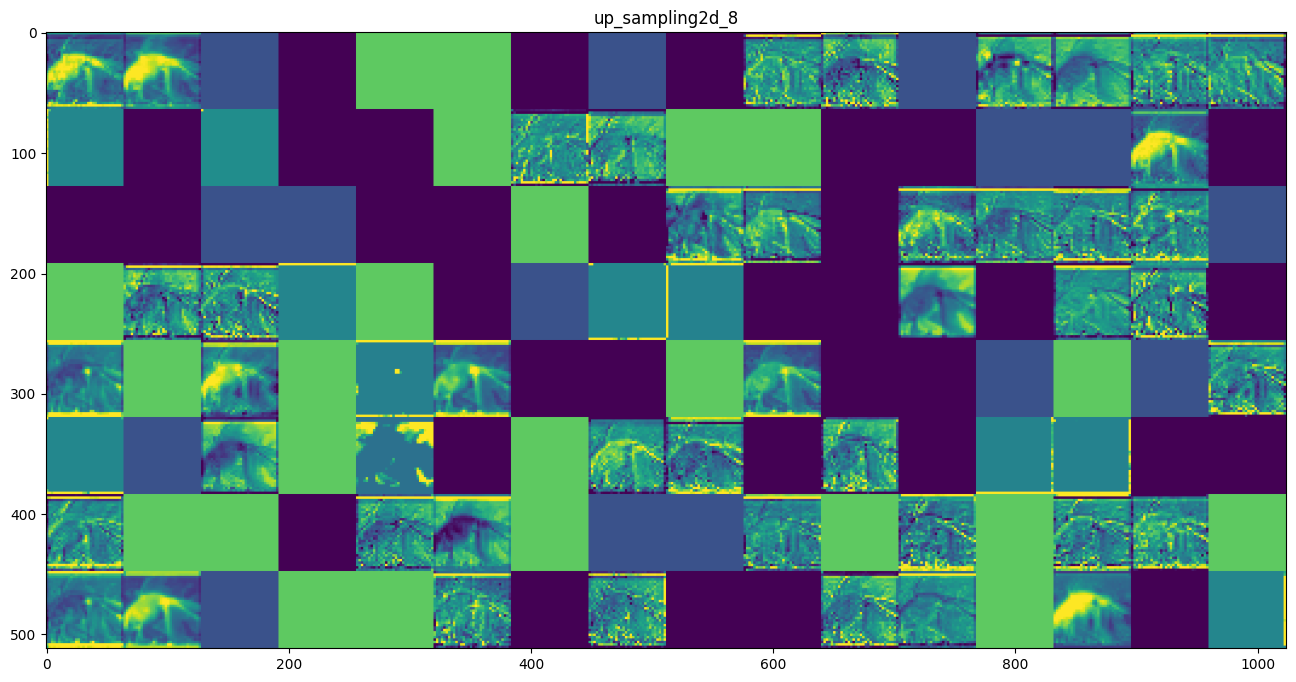

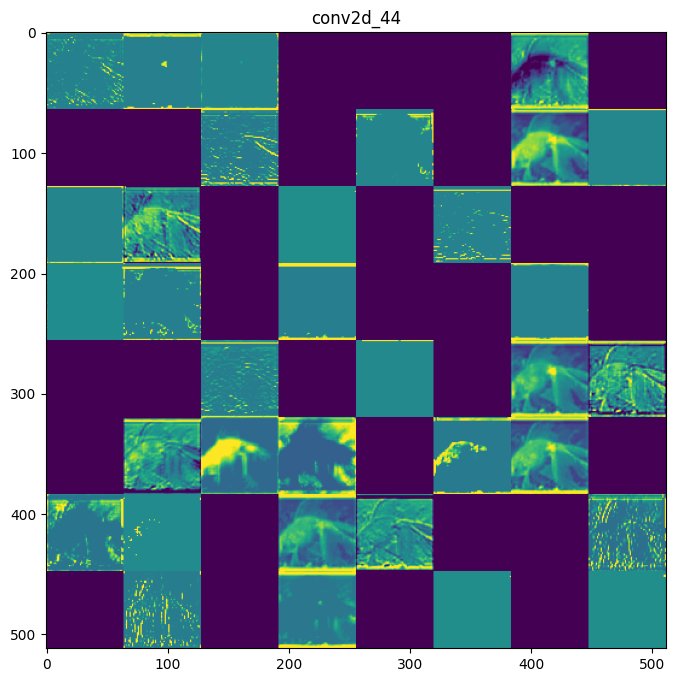

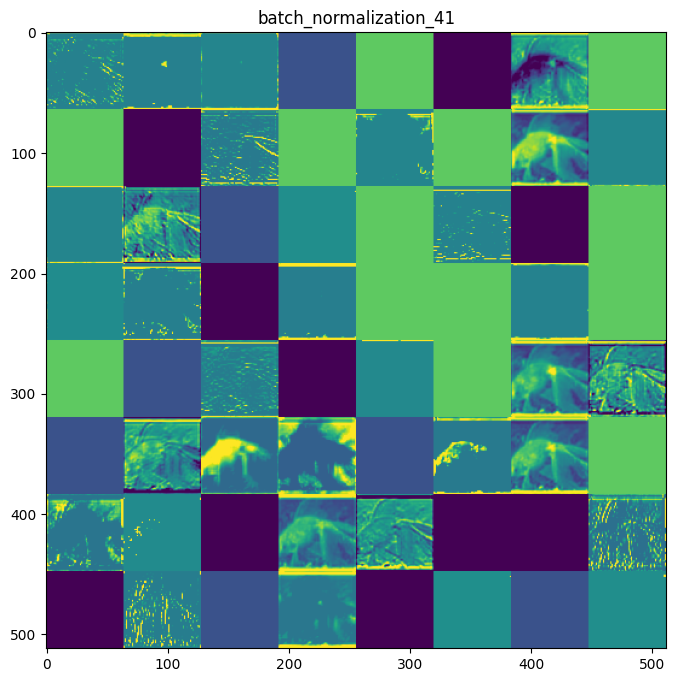

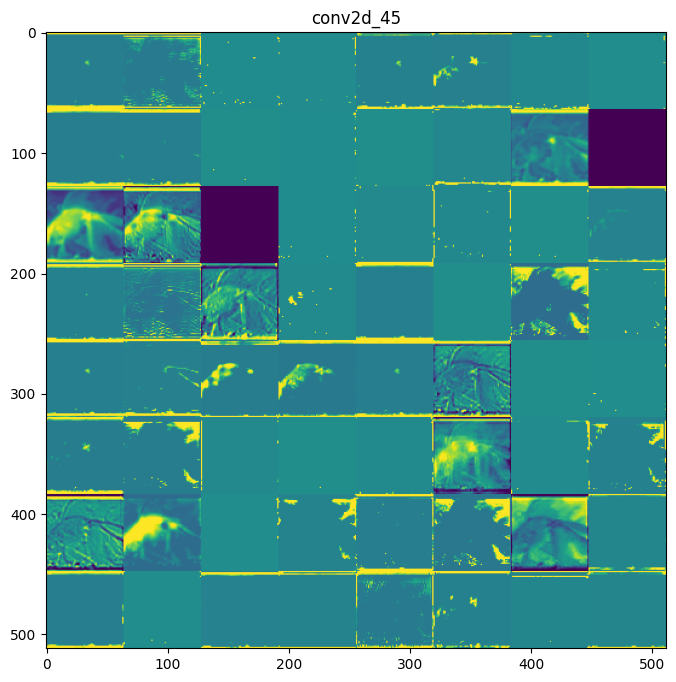

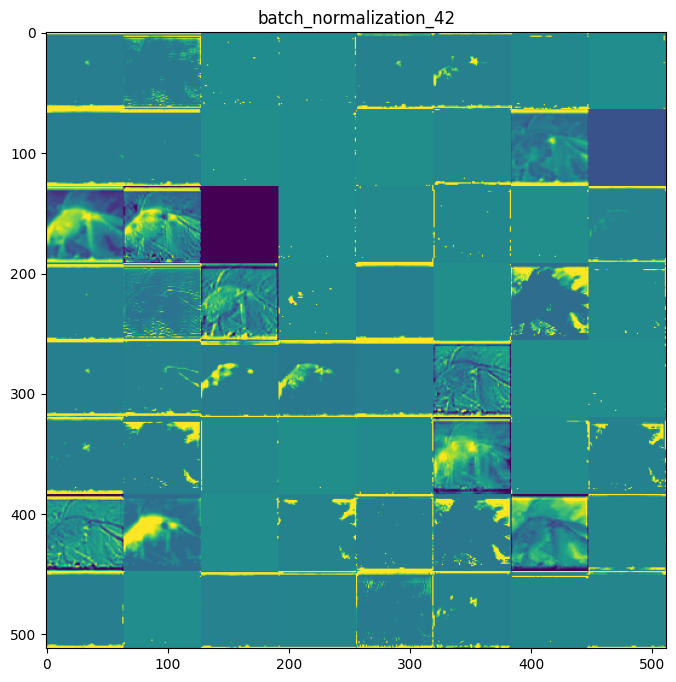


--- Displaying Final Output Layer ---


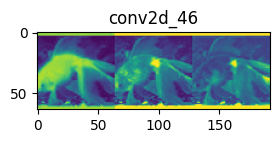

In [55]:


# Get a single test image (use the same one from the timing test)
test_image, _ = next(iter(valid_dataset))
test_image = test_image[0:1] # Shape: (1, 64, 64, 3)

# 1. Create a list of the outputs of each layer in your model
layer_outputs = [layer.output for layer in model.layers]

# 2. Create a new model that will return these outputs
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# 3. Get the activations by running a prediction
activations = activation_model.predict(test_image)

# 4. Visualize the feature maps from a specific convolutional layer
layer_names = [layer.name for layer in model.layers]

def display_activations(layer_name, activations_list):
    if layer_name not in layer_names:
        print(f"Layer {layer_name} not found in model.")
        return
    layer_index = layer_names.index(layer_name)
    layer_activation = activations_list[layer_index]

    if len(layer_activation.shape) != 4: # Skip layers that aren't 2D feature maps (like pooling)
        print(f"Skipping visualization for layer {layer_name} as it's not a 4D tensor.")
        return

    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    n_cols = n_features // 8 if n_features > 8 else n_features
    n_rows = 8 if n_features > 8 else 1
    
    # Adjust grid size if there are fewer than 8 features
    if n_cols == 0 and n_features > 0:
        n_cols = n_features
        n_rows = 1

    display_grid = np.zeros((size * n_rows, n_cols * size))

    for row in range(n_rows):
        for col in range(n_cols):
            feature_index = row * n_cols + col
            if feature_index < n_features:
                channel_image = layer_activation[0, :, :, feature_index]
                
                # --- THE FIX IS HERE ---
                # We add a tiny number (1e-8) to the standard deviation
                # to prevent it from ever being zero.
                std_dev = channel_image.std()
                if std_dev > 0:
                    channel_image -= channel_image.mean()
                    channel_image /= std_dev
                    channel_image *= 64
                    channel_image += 128
                # -----------------------

                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[row * size : (row + 1) * size, col * size : (col + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

print("--- Displaying Encoder Activations ---")
display_activations('conv2d_41', activations)
display_activations('batch_normalization_38', activations)
display_activations('conv2d_42', activations)
display_activations('batch_normalization_39', activations)
display_activations('max_pooling2d_8', activations)

print("\n--- Displaying Bottleneck Activations ---")
display_activations('conv2d_43', activations)
display_activations('batch_normalization_40', activations)

print("\n--- Displaying Decoder Activations ---")
display_activations('up_sampling2d_8', activations)
display_activations('conv2d_44', activations)
display_activations('batch_normalization_41', activations)
display_activations('conv2d_45', activations)
display_activations('batch_normalization_42', activations)

# Note: The final layer is the reconstructed image.
# While 'display_activations' will work, a simple imshow is often clearer for the final result.
print("\n--- Displaying Final Output Layer ---")
display_activations('conv2d_46', activations)


In [51]:
# This runs the model on the validation set and returns the loss
mse_loss = model.evaluate(valid_dataset)
print(f"Mean Squared Error (MSE) on validation set: {mse_loss:.6f}")

2025-10-14 13:25:07.416574: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - loss: 0.0160
Mean Squared Error (MSE) on validation set: 0.016028


In [52]:
import tensorflow as tf

# Get a batch of original and reconstructed images
original_images, _ = next(iter(valid_dataset))
reconstructed_images = model.predict(original_images)

# Denormalize images from [-1, 1] to [0, 1] for metric calculation
original_images = (original_images + 1.0) / 2.0
reconstructed_images = (reconstructed_images + 1.0) / 2.0

# Calculate metrics
psnr_value = tf.image.psnr(original_images, reconstructed_images, max_val=1.0)
ssim_value = tf.image.ssim(original_images, reconstructed_images, max_val=1.0)

# The result is a tensor of values, one for each image in the batch. We can average them.
print(f"Average PSNR on batch: {tf.reduce_mean(psnr_value):.2f} dB")
print(f"Average SSIM on batch: {tf.reduce_mean(ssim_value):.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Average PSNR on batch: 23.37 dB
Average SSIM on batch: 0.9212


In [56]:
model.summary()

Model: "Compact_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 678,155 (2.59 MB)

 Trainable params: 225,795 (882.01 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 451,592 (1.72 MB)